In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

In [2]:
DATA_DIR = ''
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'submission.csv') # самбмишн

In [3]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем данные для обработки

Признак Дата отзыва

In [55]:
# Создадим новые признаки из Даты отзыва  
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['year'] = hotels['review_date'].dt.year
hotels['month'] = hotels['review_date'].dt.month
hotels['day'] = hotels['review_date'].dt.day
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek
hotels['week'] = hotels['review_date'].dt.isocalendar().week


<AxesSubplot:>

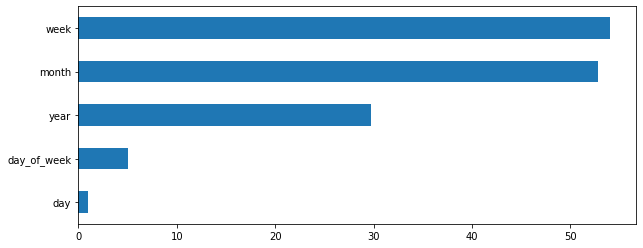

In [65]:
# Посмотрим на корреляцию целевого признака с новыми признаками на основе Даты

name_cols = ['year','month','day','day_of_week','week']
y = hotels.query('sample == 1').drop(['sample'], axis=1)['reviewer_score'].values.astype('int')
X = hotels.query('sample == 1').drop(['sample'], axis=1)[name_cols]

plt.rcParams['figure.figsize'] = (10,4)
#imp_cat = pd.Series(chi2(X, y)[0], index=name_cols)
imp_cat = pd.Series(f_classif(X, y)[0], index = name_cols) # v.19
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [66]:
# Судя по корреляции - удалим признаки 'day','day_of_week', а также исходный признак 'review_date'
hotels.drop(['day','day_of_week','review_date'],axis=1,inplace=True)

Адрес отеля

In [120]:
# Создадим новые признаки - Страна и Город
hotels['city'] = hotels['hotel_address'].apply(lambda x:x.split()[-2])
hotels['country'] = hotels['hotel_address'].apply(lambda x:x.split()[-1])

# Закодируем признаки  при помощи простой числовой кодировки
ord_encoder = ce.OrdinalEncoder()
hotels['city'] = ord_encoder.fit_transform(hotels['city'])
hotels['country'] = ord_encoder.fit_transform(hotels['country'])

Тектсы отзывов 

In [82]:
"""  В текстах отзывов есть противоречивые данные: 
- в тексте позитивного отзыва встречается "No Positive"...,
- в тексте негативного отзыва встречается "No Negative"...,
Создадим два новых признака где отметим этот факт        """

# Удалим пробелы вначале и конце строк с отзывами
hotels['positive_review'].apply(lambda x:x.strip())
hotels['negative_review'].apply(lambda x:x.strip())

#Списки часто встречающихся НЕпозитивных слов в позитивных отзывах и НЕнегативных слов в негативных отзывах
no_pos = [
    'No Positive', 
    'Nothing', 
    'nothing']
no_neg = [
    'No Negative',
    'All good',
    'Nothing really',
    'Nothing',
    'nothing',
    'N A',
    'none',
    'N a',
    'Nothing at all',
    'Nothing to dislike']
    
hotels['No Positive'] = hotels['positive_review'].apply(
    lambda x:1 if x in no_pos else 0
    )

# Очистим исходные признаки от противоречивых данных   
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x:'' if x in no_pos else x
    )
  
hotels['No Negative'] = hotels['negative_review'].apply(
    lambda x:1 if x in no_neg else 0
    )

# Очистим исходные признаки от противоречивых данных   
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x:'' if x in no_neg else x
    )


In [84]:
# Интересная особенность - 25% негативных отзывов на самом деле не негативные
hotels['No Negative'].value_counts()

0    387848
1    127890
Name: No Negative, dtype: int64

Используем библиотеку для анализа текста по эмоциональному окрасу

In [121]:
# Импортируем библиотеку
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.downloader.download('vader_lexicon')

analizer = SentimentIntensityAnalyzer()
# Создаем новые признаки для эмоциональной окраски 
hotels['neg_sent'] = hotels['negative_review'].apply(lambda x: analizer.polarity_scores(x))
hotels['pos_sent'] = hotels['positive_review'].apply(lambda x: analizer.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [136]:
# Создаем новые признаки из результатов анализа текстов
hotels['neg_sent_neg'] = hotels['neg_sent'].apply(lambda x: x['neg'])
hotels['neg_sent_neu'] = hotels['neg_sent'].apply(lambda x: x['neu'])
hotels['neg_sent_pos'] = hotels['neg_sent'].apply(lambda x: x['pos'])
hotels['neg_sent_comp'] = hotels['neg_sent'].apply(lambda x: x['compound'])

hotels['pos_sent_neg'] = hotels['pos_sent'].apply(lambda x: x['neg'])
hotels['pos_sent_neu'] = hotels['pos_sent'].apply(lambda x: x['neu'])
hotels['pos_sent_pos'] = hotels['pos_sent'].apply(lambda x: x['pos'])
hotels['pos_sent_comp'] = hotels['pos_sent'].apply(lambda x: x['compound'])

Тэги

In [137]:
""" Найдем популярные тэги и создадим новые признаки с полезными данными """
# Ищем популярные тэги
def get_tags(string):
    s = string.split("' ")[1:]
    for i in range(len(s)):
        s[i] = s[i].lstrip().replace(" ', ","")
    s[len(s)-1] = s[len(s)-1].replace(" ']","")
    return (s)

hotels['set_tags'] = hotels['tags'].apply(get_tags)
tags_set = set()
for tags in hotels['set_tags']:
    for tag in tags:
        tags_set.add(tag)

dict_tags = dict.fromkeys(list(tags_set),0)
for tags in hotels['set_tags']:
    for tag in tags:
        dict_tags[tag] += 1

usage_tags = pd.DataFrame(data = {'tag':list(tags_set),'count':0})
for i in range(len(usage_tags)):
    usage_tags.loc[i,'count'] = dict_tags[usage_tags.loc[i,'tag']]

# Выбираем 20 самых популярных и сохраняем в список
top_tags = list(usage_tags.sort_values(
    by = 'count', ascending = False).head(20)['tag']
    )
display(top_tags)


['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room']

In [124]:
# Сделаем копию данных
hotels2 = hotels.copy()

# Создадим новые признаки из популярных тэгов, используя ohe_hot кодирование
# Массив Numpy значительно ускоряет работу - без него выполнялось дольше в десятки раз.

# Что из тэгов может влиять на рейтинг?
# Субъективная оценка говорит о том, что тип номера или цель путешествия врядли влияют
# Поэтому остановимся на следующих признаках
# - количество ночей
# - Couple
# - Solo traveler
# - Family with young children
# - Family with older children
top_tags_manual = ['Couple','Solo traveler','Family with young children','Family with older children']

# Создадим новые признаки методом one_hot кодирования
array2 = np.zeros((len(hotels2)+1,len(top_tags_manual)+1),dtype=int)
for i in range(len(hotels2)):
    for str in hotels2.loc[i,'tags']:
        for j in range(len(top_tags_manual)):
            if str == top_tags_manual[j]:
                array2[i,j] = 1
                break
# Создаем новые признаки и записываем в них данные из массива
for j in range(len(top_tags_manual)):
    hotels2.loc[:,top_tags_manual[j]] = array2[:-1,j]

In [ ]:
# Создадим признак - количество ночей, данные берем из тэгов
array2 = np.zeros((len(hotels2)+1,1),dtype=int)

for i in range(len(hotels)):
    for tag in hotels.loc[i,'set_tags']:
        words = tag.split()
        if words[0] == 'Stayed':
            array2[i] = int(words[1])
            break

hotels2['stayed'] = array2[:-1]

In [126]:
# Создаем новые признаки - пропорции плохих и хороших слов на основании исходных данных
hotels2['word_positive_part'] = hotels2['review_total_positive_word_counts']/(hotels2['review_total_negative_word_counts']+hotels2['review_total_positive_word_counts'])
hotels2['word_negative_part'] = hotels2['review_total_negative_word_counts']/(hotels2['review_total_negative_word_counts']+hotels2['review_total_positive_word_counts'])
hotels2['word_positive_part'].fillna(0,inplace=True)
hotels2['word_negative_part'].fillna(0,inplace=True)

In [128]:
X = hotels2.drop(['reviewer_score'], axis = 1)  
y = hotels2[hotels2['sample'] == 1]['reviewer_score'] 
X = X[X['sample'] == 1].drop([
    'hotel_address',
    'hotel_name',
    'reviewer_nationality',
    'negative_review',
    'positive_review',
    'tags',
    'days_since_review',
    'set_tags',
    'lat',
    'sample',
    'neg_sent',
    'pos_sent'
    ], axis = 1)
X['lng'].fillna(X['lng'].median(),inplace=True)

In [129]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# проверяем
y_test, y_train.shape, X.shape, X_train.shape, X_test.shape

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель
RANDOM_SEED = 42
regr = RandomForestRegressor(n_estimators=100,verbose=1, n_jobs=-1, random_state=RANDOM_SEED)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s


MAPE: 0.12620394798748277


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


In [134]:
X = hotels2.drop(['reviewer_score'], axis = 1)
X = X[X['sample'] == 0].drop([
    'hotel_address',
    'hotel_name',
    'reviewer_nationality',
    'negative_review',
    'positive_review',
    'tags',
    'days_since_review',
    'set_tags',
    'lat',
    'sample',
    'neg_sent',
    'pos_sent'
    ], axis = 1)
X['lng'].fillna(X['lng'].median(),inplace=True)

final_pred = regr.predict(X)

#print('MAPE:', metrics.mean_absolute_percentage_error(y, final_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


In [135]:
sample_submission['reviewer_score'] = final_pred
sample_submission.to_csv('submission4.csv',index=False)

<AxesSubplot:>

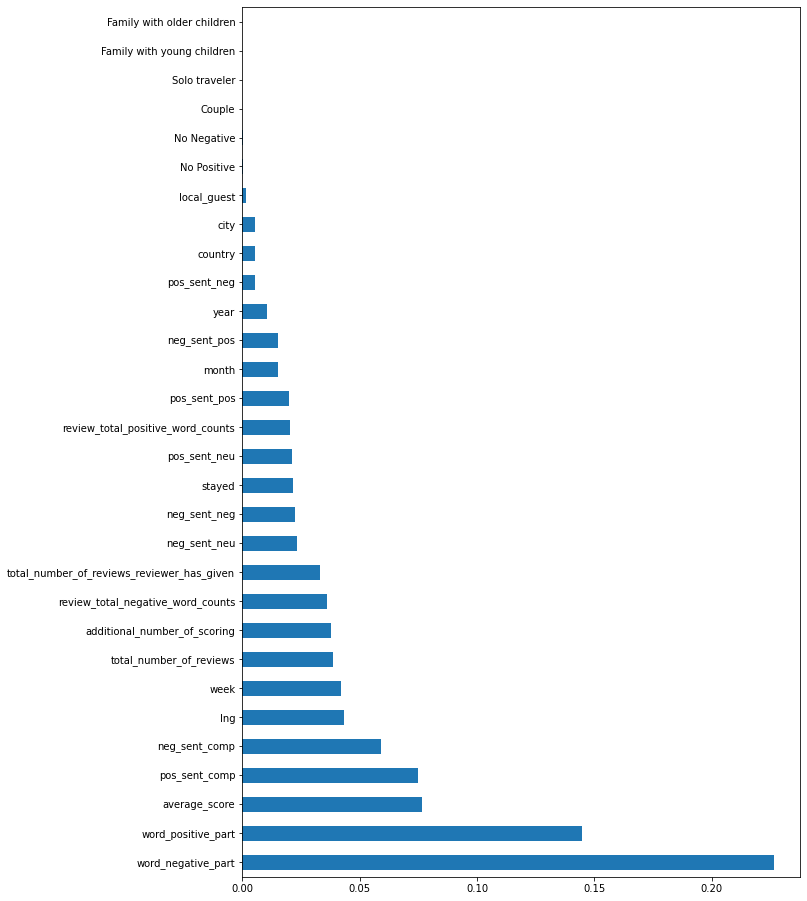

In [130]:
# импортируем библиотеки для визуализации

plt.rcParams['figure.figsize'] = (10,16)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')